In [1]:
import os
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import geoplotlib
import seaborn as sns

sns.set_theme(style="darkgrid")
import altair as alt


# I. Load in Data

In [21]:
DATA_PATH='../../SCHOOL/INFO633/ASSIN 3/data/'
population_df=DATA_PATH+'population_df.xlsx'
final_covid_df=DATA_PATH+'DAILY_SUMS.xlsx'
percent_df=DATA_PATH+'PERCENT_DATA.xlsx'
daily_change=DATA_PATH+'DIFF_SUM_DATA.xlsx'
old_clean_df=DATA_PATH+'OLD_CLEAN_DATASET.xlsx'


---

In [22]:
POP_DATA=pd.read_excel(population_df)
COVID_DATA=pd.read_excel(final_covid_df, parse_dates=['Date'])
PERCENT_DATA=pd.read_excel(percent_df, parse_dates=['Date'])
DELTA_DATA=pd.read_excel(daily_change, parse_dates=['Date'])

original_df=pd.read_excel(old_clean_df, parse_dates=['Date'])

---
#### STATES NOT REPORTING RACE DATA:

In [6]:
for state_i in np.unique(original_df['State']):
    if np.sum(original_df['Cases_White'][original_df['State']==state_i])==0:
        print(state_i)

NY


---
# II. Plotting Timeline of Cases or Deaths

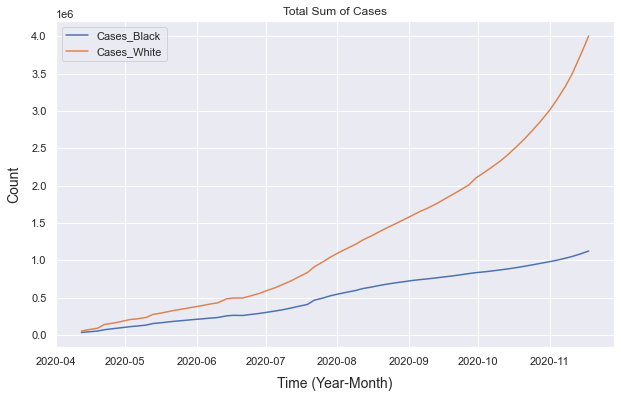

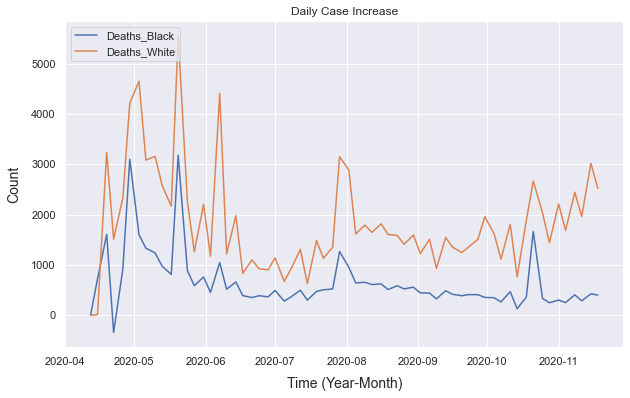

In [7]:
def time_plotter(data_set, case_type, title, add_width=False, y_axis='Count', save=False, size=(10,6), format_save='eps'):
    _=plt.figure(figsize=size)
    widths=POP_DATA[POP_DATA.columns[1:]].iloc[1]/10
    widths['Cases_Total']=1
    for case_i in case_type:
        if add_width==True:
            #widths=[1]
            #widths.append(POP_DATA[case_i].iloc[1]/10)
            _=plt.plot(data_set['Date'], data_set[case_i], label=case_i, linewidth=widths[case_i], alpha=0.75)#POP_DATA[case_i].iloc[1]/10)
        else:
            _=plt.plot(data_set['Date'], data_set[case_i], label=case_i)
    _=plt.legend(loc=2)
    _=plt.xlabel('Time (Year-Month)', fontsize=14, labelpad=10)
    _=plt.ylabel(y_axis, fontsize=14, labelpad=10)
    _=plt.title(title)
    if save:
        _=plt.savefig(DATA_PATH+'figs/'+save+'.'+format_save, format=format_save)#+'.jpeg')

    
#time_plotter(COVID_DATA, ['Cases_Black', 'Cases_White'], 'Total Sum of Cases', add_width=False)#, save='White_Black_Cases')    
#time_plotter(DELTA_DATA, ['Deaths_Black', 'Deaths_White'], 'Daily Case Increase')#, save='White_Black_CaseDelta')    

----

# III. Collect only the race related columns (cases and deaths) and scale each point by the total population size and per capita (100k people)
 - Also create a delta cases and deaths between dates


In [10]:
POPULATION_SCALED_DF=pd.DataFrame({'Date':np.unique(COVID_DATA['Date'])})
POPULATION_SCALED_DF_DELTA=pd.DataFrame({'Date':np.unique(DELTA_DATA['Date'])})

# Total Cases (race only) 
for percent, pop_cent in zip(COVID_DATA[COVID_DATA.columns[1:9]],POP_DATA[POP_DATA.columns[:]]):
    POPULATION_SCALED_DF[percent]=COVID_DATA[percent]/POP_DATA[pop_cent].iloc[0]
    POPULATION_SCALED_DF[percent+'_per_100k']=COVID_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100000
    
# Total Deaths (race only)
for percent, pop_cent in zip(COVID_DATA[COVID_DATA.columns[14:22]],POP_DATA[POP_DATA.columns[:]]):
    POPULATION_SCALED_DF[percent]=COVID_DATA[percent]/POP_DATA[pop_cent].iloc[0]
    POPULATION_SCALED_DF[percent+'_per_100k']=COVID_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100000

# Change in Cases (race only)
for percent, pop_cent in zip(DELTA_DATA[DELTA_DATA.columns[1:9]],POP_DATA[POP_DATA.columns[:]]):
    POPULATION_SCALED_DF_DELTA[percent]=DELTA_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100
    POPULATION_SCALED_DF_DELTA[percent+'_per_100k']=DELTA_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100000

# Change in Deaths (race only)
for percent, pop_cent in zip(DELTA_DATA[DELTA_DATA.columns[14:22]],POP_DATA[POP_DATA.columns[:]]):
    POPULATION_SCALED_DF_DELTA[percent]=DELTA_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100
    POPULATION_SCALED_DF_DELTA[percent+'_per_100k']=DELTA_DATA[percent]/POP_DATA[pop_cent].iloc[0]*100000


In [15]:
POPULATION_SCALED_DF.to_excel(DATA_PATH+'scaled_pop_df.xlsx')
POPULATION_SCALED_DF_DELTA.to_excel(DATA_PATH+'scaled_pop_df_delta.xlsx')

In [42]:
new_cols=['Date']
new_cols.extend(list(COVID_DATA.columns[2:9]))

df_ts=DELTA_DATA[new_cols]
df_percent=POPULATION_SCALED_DF[new_cols]

#df_percent[df_percent.columns[1:]=df_percent[df_percent.columns[1:]]*weight
df_ts.index=df_ts['Date']
df_percent.index=df_percent['Date']
df_ts=df_ts.drop(columns='Date')
df_percent=df_percent.drop(columns='Date')

df_ts=df_ts.rename(columns={'Cases_White':'White','Cases_Black':'Black','Cases_LatinX':'LatinX',
                            'Cases_Asian':'Asian',
                            'Cases_AIAN':'AIAN', 'Cases_NHPI':'NHPI', 'Cases_Multiracial':'Multiracial'})

df_percent=df_percent.rename(columns={'Cases_White':'White','Cases_Black':'Black','Cases_LatinX':'LatinX',
                            'Cases_Asian':'Asian',
                            'Cases_AIAN':'AIAN', 'Cases_NHPI':'NHPI', 'Cases_Multiracial':'Multiracial'})

# III. Create 2-day rolling average mean cases and create "long-form" dataframe for altair handling
- create streamgraph-type graph

In [45]:
s=df_ts.rolling(2).mean()
s2=df_percent.rolling(2).mean()
s['Date']=s.index
s2['Date']=s.index

delta_melt=s.melt('Date', var_name='Race', value_name='Cases')
delta_melt_perc=s2.melt('Date', var_name='Race', value_name='Cases')

In [52]:
alt.Chart(delta_melt_perc).mark_area().encode(
   # alt.sort()
    alt.X('Date:T',
        axis=alt.Axis(format='%b-%d', tickCount=15, title='Month')
    ),
    alt.Y('Cases:Q', stack='normalize', sort=list(COVID_DATA.columns[2:9]), title='Cases',axis=alt.Axis(orient='right')),#         axis=alt.Axis(domain=False, tickSize=1)),
    alt.Color('Race:N',
        scale=alt.Scale(scheme='tableau10'),
              sort=list(COVID_DATA.columns[2:9]),
              legend=alt.Legend(orient="left")
    )
).properties(
    width=500,
    height=400
).configure_axisY(
    titleAngle=0,
    titleAlign="left",
)#.interactive()

alt.Chart(...)